In [1]:
# demonstrate face detection on 5 Celebrity Faces Dataset
from os import listdir
import os
from PIL import Image
from numpy import asarray
import numpy as np
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

/home/FRACTAL/ashish.palve/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/FRACTAL/ashish.palve/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/FRACTAL/ashish.palve/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/FRACT

In [2]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    print(filename)
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

In [ ]:
# specify folder to plot
folder = 'Male_Female_Backup/train/Male/'
i = 1
# enumerate files
for filename in listdir(folder):
    # path
    path = folder + filename
    # get face
    print(filename)
    face = extract_face(path)
    print(i, face.shape)
    # plot
    pyplot.subplot(42, 7, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()

In [3]:
# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_face(path)
        # store
        faces.append(face)
    return faces

In [4]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not os.path.isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [5]:
# load train dataset
trainX, trainy = load_dataset('Male_Female_Backup/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('Male_Female_Backup/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
np.savez_compressed('Male_Female_Backup-dataset.npz', trainX, trainy, testX, testy)

Male_Female_Backup/train/Female/images39.jpg


Male_Female_Backup/train/Female/images35.jpg
Male_Female_Backup/train/Female/images46.jpg
Male_Female_Backup/train/Female/image7.jpeg
Male_Female_Backup/train/Female/images16.jpg
Male_Female_Backup/train/Female/images40.jpg
Male_Female_Backup/train/Female/images8.jpg
Male_Female_Backup/train/Female/image24.jpeg
Male_Female_Backup/train/Female/images4.jpg
Male_Female_Backup/train/Female/images19.jpg
Male_Female_Backup/train/Female/image27.jpeg
Male_Female_Backup/train/Female/images17.jpg
Male_Female_Backup/train/Female/images10.jpg
Male_Female_Backup/train/Female/image14.jpeg
Male_Female_Backup/train/Female/image16.jpeg
Male_Female_Backup/train/Female/images13.jpg
Male_Female_Backup/train/Female/images43.jpg
Male_Female_Backup/train/Female/images.jpg
Male_Female_Backup/train/Female/images11.jpg
Male_Female_Backup/train/Female/images5.jpg
Male_Female_Backup/train/Female/images27.jpg
Male_Female_Backup/train/Female/image11.jpeg
Male_Female_Ba

In [6]:
# load the face dataset
data = np.load('Male_Female_Backup-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (100, 160, 160, 3) (100,) (30, 160, 160, 3) (30,)


In [7]:
# example of loading the keras facenet model
from keras.models import load_model
# load the model
#model = load_model('facenet_keras.h5')

In [8]:
model = load_model('facenet_keras.h5')
print('Loaded Model')

Loaded Model


/home/FRACTAL/ashish.palve/.local/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

In [10]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [11]:
data = load('Male_Female_Backup-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')

Loaded:  (100, 160, 160, 3) (100,) (30, 160, 160, 3) (30,)
Loaded Model


/home/FRACTAL/ashish.palve/.local/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

(100, 128)


In [13]:
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

(30, 128)


In [14]:
# save arrays to one file in compressed format
savez_compressed('Male_Female_Backup-embeddings.npz', newTrainX, trainy, newTestX, testy)

In [15]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

In [16]:
# load dataset
data = load('Male_Female_Backup-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=100, test=30


In [17]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

In [18]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [19]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)

In [21]:
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=92.000, test=80.000


In [22]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

In [23]:
# load faces
data = load('Male_Female_Backup-dataset.npz')
testX_faces = data['arr_2']

In [24]:
# load face embeddings
data = load('Male_Female_Backup-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [25]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [26]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

/home/FRACTAL/ashish.palve/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [43]:
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

Predicted: Male (97.985)
Expected: Male


/home/FRACTAL/ashish.palve/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


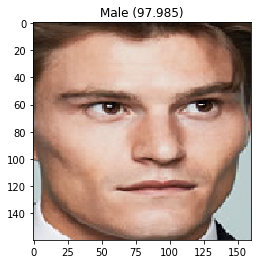

In [44]:
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()